### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [31]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [32]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [34]:
SEED = 100500

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Data preprocessing

In [35]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [36]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [37]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [38]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [39]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [40]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9225
Unique tokens in target (en) vocabulary: 6682


Here are tokens from original (RU) corpus:

In [41]:
SRC.vocab.itos[::1000]

['<unk>',
 'сауну',
 'agriturismo',
 'лыжной',
 'bed',
 'эр',
 'm4',
 'уже',
 'доломити',
 'трулло']

And from target (EN) corpus:

In [42]:
TRG.vocab.itos[::1000]

['<unk>', 'addition', 'infinity', 'chez', 'military', 'squeezed', 'mihailova']

And here is example from train dataset:

In [43]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'hotel', 'has', 'a', 'large', 'swimming', 'pool', 'with', 'a', 'section', 'for', 'children', ',', 'plus', 'a', 'children', "'", 's', 'playground', '.'], 'src': ['в', 'отеле', 'есть', 'большой', 'бассейн', 'с', 'секцией', 'для', 'детей', ',', 'а', 'также', 'детская', 'площадка', '.']}


Let's check the length distributions:

Length distribution in Train data


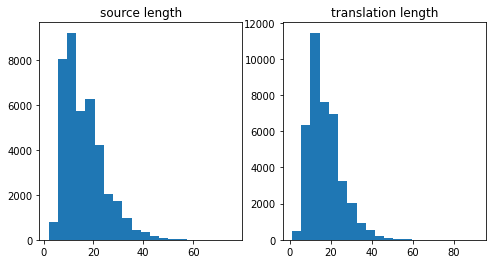

In [44]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


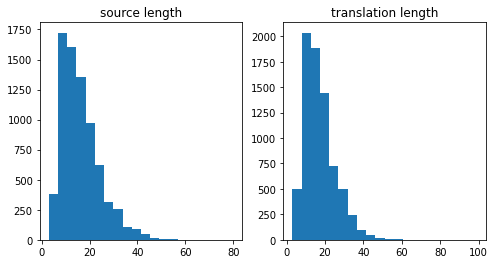

In [45]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
device

device(type='cuda')

In [48]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [49]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 40x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 46x128 (GPU 0)]
torch.Size([46, 128]) torch.Size([40, 128])


###Baseline Model

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import sys
sys.path.insert(0, '/content/drive/My Drive')

In [52]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [53]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [54]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9225, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6682, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6682, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,856,474 trainable parameters


In [56]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [62]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, batch_first=False):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()

        if batch_first:
            output, _ = model(src, trg[:,:-1])
            output = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:,1:].contiguous().view(-1)
        else:
            output = model(src, trg)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

 
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [63]:
def evaluate(model, iterator, criterion, batch_first = False):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            if batch_first:
                output, _ = model(src, trg[:,:-1])
                output = output.contiguous().view(-1, output.shape[-1])
                trg = trg[:,1:].contiguous().view(-1)
            else:
                output = model(src, trg, 0)
                output = output[1:].view(-1, output.shape[-1])
                trg = trg[1:].view(-1)


            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [64]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [65]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [66]:
import os
path = os.getcwd() + "/drive/MyDrive/"

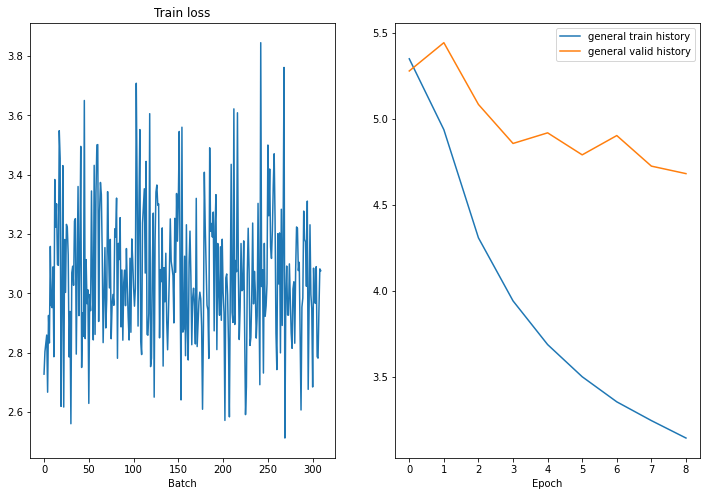

Epoch: 10 | Time: 1m 46s
	Train Loss: 3.057 | Train PPL:  21.263
	 Val. Loss: 4.761 |  Val. PPL: 116.851


In [67]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path + 'baseline_model')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [68]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [69]:
batch = next(iter(test_iterator))

In [70]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: , a 24 - hour front desk .

Original: free parking is provided .
Generated: free parking .



In [71]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [72]:
import tqdm

In [74]:
model.load_state_dict(torch.load(path + 'baseline_model'))
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 13.43it/s]


In [75]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.53909488730259

BLEU-score of baseline model is not good enough. 

###Experiment 1

Let's change LSTM to GRU and try to give the last encoder's state as additional input vector on each step of decoder.

In [76]:
import GRU_network
Encoder = GRU_network.Encoder
Decoder = GRU_network.Decoder
Seq2Seq = GRU_network.Seq2Seq

In [77]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [78]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,783,706 trainable parameters


In [79]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [80]:
import os
path = os.getcwd() + "/drive/MyDrive/"

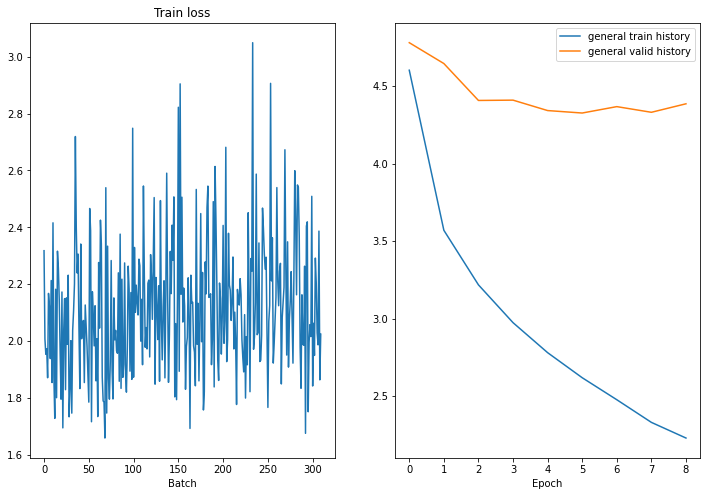

Epoch: 10 | Time: 1m 46s
	Train Loss: 2.117 | Train PPL:   8.307
	 Val. Loss: 4.435 |  Val. PPL:  84.385


In [81]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path + 'GRU_model_last_state_as_input')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [82]:
model.load_state_dict(torch.load(path + 'GRU_model_last_state_as_input'))
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 13.58it/s]


In [83]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

21.197979165737728

In [89]:
print('Bad example:')
print(' '.join(original_text[150]))
print(' '.join(generated_text[150]), '\n')
print('Not so bad example:')
print(' '.join(original_text[17]))
print(' '.join(generated_text[17]), '\n')
print('Good example:')
print(' '.join(original_text[50]))
print(' '.join(generated_text[50]))

Bad example:
the property offers free parking .
free parking is available on site . 

Not so bad example:
there is a 24 - hour front desk at the property .
you will find a 24 - hour front desk at the property . 

Good example:
guests can enjoy the on - site bar .
guests can enjoy the on - site bar .


BLEU-score in this experiment is much better, but it is still quite low. What's more, as in baseline model, validation loss is not decreasing. It seems like this network also just memorizes train dataset and does not learn to translate.

###Experiment 2



Let's try to implement CNN encoder and decoder with positional encoding.

Encoder's side: On each convolution layer we add paddings from both sides to make the number of output vetors equal to the number of input vectors. Skip connections are used after each layer to combine convolution output with its central input. Let's also add skip connection between original input(word embedding + position embbeding)and the output after all convolutional layers. 

Decoder's side: Similar to encoder, but paddings just from left side to make sure we do not look at the next token. On each layer after convolution and activation we add information from encoder: original input(word embedding + position embbeding), conved vector after all convolutional layers and same conved vector combined with original input. Skip connections are used in similar manner. 

In [90]:
import os
path = os.getcwd() + "/drive/MyDrive/"

In [91]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [92]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [93]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [94]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device,
     sort_key=_len_sort_key)

In [121]:
sys.path.insert(0, '/content/drive/My Drive')

import Conv_enc_dec_network
Encoder = Conv_enc_dec_network.Encoder
Decoder = Conv_enc_dec_network.Decoder
Seq2Seq = Conv_enc_dec_network.Seq2Seq

In [122]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 8
KERNEL_SIZE = 3 
DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi['<pad>']
SRC_PAD_IDX = SRC.vocab.stoi['<pad>']
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, KERNEL_SIZE, DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, KERNEL_SIZE, DROPOUT, PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [97]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 31,826,500 trainable parameters


In [98]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

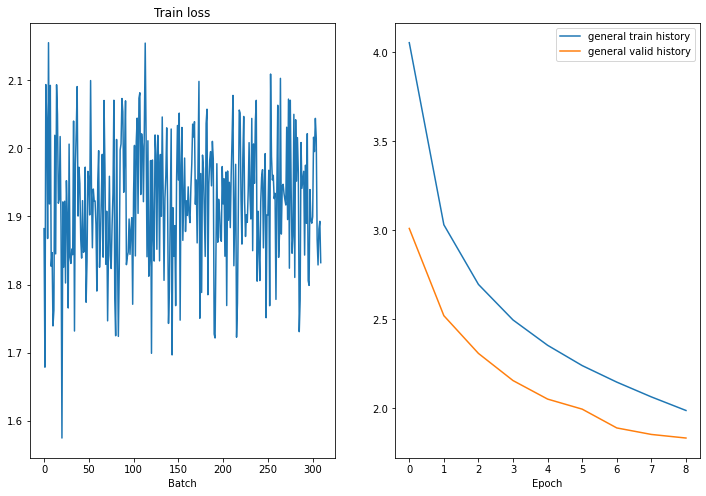

Epoch: 10 | Time: 2m 1s
	Train Loss: 1.921 | Train PPL:   6.830
	 Val. Loss: 1.773 |  Val. PPL:   5.890


In [99]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP / (epoch + 1), train_history, valid_history, batch_first = True)
    valid_loss = evaluate(model, valid_iterator, criterion, batch_first = True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path + 'Cnn_enc_dec_model')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [123]:
model.load_state_dict(torch.load(path + 'Cnn_enc_dec_model'))
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output, _ = model(src, trg[:,:-1]) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        #output = output.argmax(dim=-1)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[:].detach().cpu().numpy()])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 15.35it/s]


In [124]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.95615814716703

In [138]:
print('Not so good translations with repeated words in output:\n')
print(' '.join(original_text[0]))
print(' '.join(generated_text[0]), '\n')
print(' '.join(original_text[10]))
print(' '.join(generated_text[10]), '\n')
print(' '.join(original_text[48]))
print(' '.join(generated_text[48]), '\n')
print(' '.join(original_text[17]))
print(' '.join(generated_text[17]), '\n')

print('Good examples:')
print(' '.join(original_text[4]))
print(' '.join(generated_text[4]), '\n')

print(' '.join(original_text[140]))
print(' '.join(generated_text[140]), '\n')

Not so good translations with repeated words in output:

the motorway is also nearby .
the motorway is nearby nearby . 

you will find a hairdresser ' s at the property .
you can find a hairdresser at at at the property . 

free guarded private parking is offered .
free secure parking parking is available . 

it provides a 24 - hour front desk for the convenience of the guests .
there operates a 24 - hour front desk and a 24 of reception reception . 

Good examples:
there is a 24 - hour front desk at the property .
there is a 24 - hour front desk at the property . 

a tv is provided .
a tv is provided . 



Great score, it is already higher than 29. Validation loss is decreasing. Seems like no problem with overfitting.

However, there are still 2 problems:

1)Number of learning parameters is huge. 
2)We have repeating words in our translation in many cases. 

###Experiment 3
Next idea is to implement self-attention techniques like it was described in lecture 5. We will write a network which deals with multi-head attention and try to learn model with just one head and 5 layers in this experiment and with 8 heads and 3 layers in the next section.

Encoder's side: Same as conv encoder, this one produces context vectors, which contain information about whole sentence. Number of context мectors is equal to number of tokens in the source sentence. Surce sentnce is passed into the multi-head attention layer, then we perform dropout on it, apply a skip-connection and pass it through a normalization layer. 

Decoder's side: similar to encoder, but it has two multi-head attention layers. First one is just on target embeddings, second uses the decoder representation as the query and the encoder representation as the key and value.

In [140]:
sys.path.insert(0, '/content/drive/My Drive')

import Multihead_attention_network
Encoder = Multihead_attention_network.Encoder
Decoder = Multihead_attention_network.Decoder
Seq2Seq = Multihead_attention_network.Seq2Seq

In [141]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
N_LAYERS = 5
N_HEADS = 1
PF_DIM = 512
DROPOUT = 0.1
    
enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, N_HEADS, PF_DIM, DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, N_HEADS, PF_DIM, DROPOUT, device)


model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [142]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,434,756 trainable parameters


In [106]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

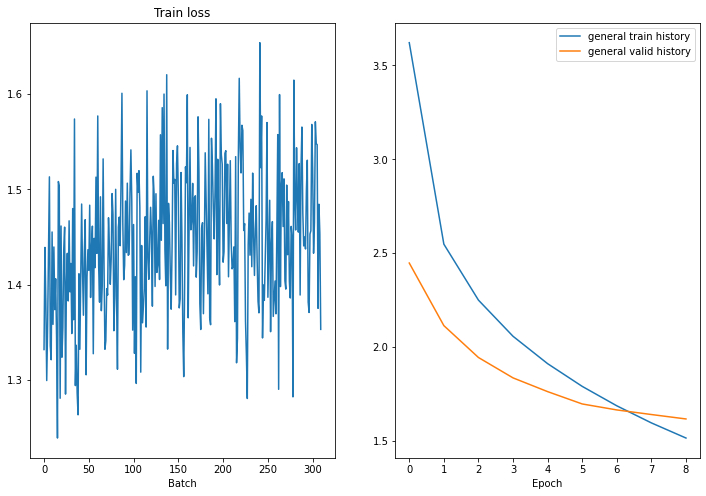

Epoch: 10 | Time: 1m 1s
	Train Loss: 1.445 | Train PPL:   4.240
	 Val. Loss: 1.605 |  Val. PPL:   4.975


In [107]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, batch_first = True)
    valid_loss = evaluate(model, valid_iterator, criterion, batch_first = True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path + 'Attention_model')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [143]:
model.load_state_dict(torch.load(path + 'Attention_model'))
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output, _ = model(src, trg[:,:-1]) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        #output = output.argmax(dim=-1)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[:].detach().cpu().numpy()])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:01, 32.12it/s]


In [144]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

35.24793236805081

In [151]:
print('Not so good translations:\n')
print(' '.join(original_text[0]))
print(' '.join(generated_text[0]), '\n')
print(' '.join(original_text[17]))
print(' '.join(generated_text[17]), '\n')

print('Good examples:')
print(' '.join(original_text[4]))
print(' '.join(generated_text[4]), '\n')

print(' '.join(original_text[123]))
print(' '.join(generated_text[123]), '\n')



Not so good translations:

the motorway is also nearby .
the motorway motorway is located nearby . 

free guarded private parking is offered .
free secure parking parking is available . 

it provides a 24 - hour front desk for the convenience of the guests .
there has a 24 - hour front desk . guests convenience of the convenience . 

Good examples:
there is a 24 - hour front desk at the property .
there is a 24 - hour front desk at the property . 

towels are available .
towels are available . 



BLEU is higher. Learning is twice faster. Bad translations are not often. Inference stage is x2.5 faster. This model is definitely the best one up to this moment.

###Experiment 4
Multihead Attention mechanism

In [152]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
N_LAYERS = 3
N_HEADS = 8
PF_DIM = 512
DROPOUT = 0.1
    
enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, N_HEADS, PF_DIM, DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, N_HEADS, PF_DIM, DROPOUT, device)


model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [113]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,798,980 trainable parameters


In [114]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

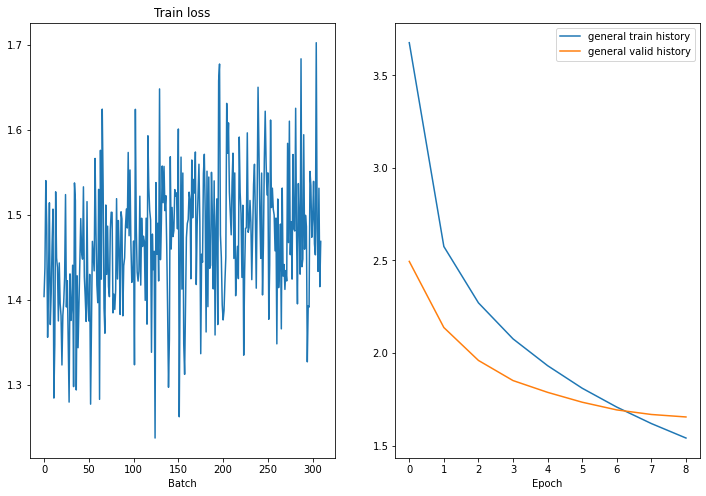

Epoch: 10 | Time: 0m 49s
	Train Loss: 1.469 | Train PPL:   4.345
	 Val. Loss: 1.644 |  Val. PPL:   5.178


In [115]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, batch_first = True)
    valid_loss = evaluate(model, valid_iterator, criterion, batch_first = True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path + 'Multihead_model')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [155]:
model.load_state_dict(torch.load(path + 'Multihead_model'))
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output, _ = model(src, trg[:,:-1]) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        #output = output.argmax(dim=-1)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[:].detach().cpu().numpy()])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:01, 39.44it/s]


In [156]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

34.66709831658365

In [157]:
print('Not so good translations:\n')
print(' '.join(original_text[0]))
print(' '.join(generated_text[0]), '\n')
print(' '.join(original_text[17]))
print(' '.join(generated_text[17]), '\n')

print('Good examples:')
print(' '.join(original_text[4]))
print(' '.join(generated_text[4]), '\n')

print(' '.join(original_text[123]))
print(' '.join(generated_text[123]), '\n')

Not so good translations:

the motorway is also nearby .
the motorway motorway is nearby nearby . 

it provides a 24 - hour front desk for the convenience of the guests .
you operates a 24 - hour front desk . assistance convenience of the property . 

Good examples:
there is a 24 - hour front desk at the property .
you is a 24 - hour front desk at the property . 

towels are available .
towels are featured . 



Model quality is a little bit worse and it can be seen on the same sentences from experiment 3. However, the inference stage is a little bit quicker. It means if we are ready to sacrifice quality for faster performance, this model is the best solution.